In [270]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

## input files

In [271]:
# farinotti = gpr_path + 'RGI60-02/RGI60-02.00147_thickness.tif'
# farinotti

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


2.0492704


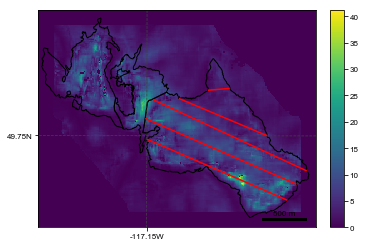

In [272]:
# season
balance = 'ba'  # bw or ba (winter or annual)
rho_snow = 470. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = 2017 # any of: 2016, 2017, 2018
I = np.abs(year - 2016) # for selecting raster inputs

gl = 0 # number to select glacier
Glacier = ['Kokanee', 'Conrad']
glacier = ['kokanee', 'conrad']
d = 10. #20.  #distance between flux gate points
Dint = 1.0 #depth integrated velocity ratio, 1.0= all sliding
sVZ = 4.91  #velocity against stake measurements
sHopt = 0.1 #10.3 ## ME:10.3 m,  MAE:0.223 (percent ratio)

fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/'
vf_list = ['img1_20150419__img2_20160417_vmap_5m_35px_spm2/', 'img1_20160417__img2_20170521_vmap_5m_35px_spm2/',
      'img1_20160417__img2_20170521_vmap_5m_35px_spm2/' ]#

# vf_list = ['img1_20150419__img2_20160417_vmap_5m_35px_spm2/', 'img1_20160913__img2_20170521_vmap_5m_35px_spm2/',
#       'img1_20160417__img2_20170521_vmap_5m_35px_spm2/' ]


vf = vf_list[I]
vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/' + vf 

topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20150912_kokanee_ppp_dem1_clip.tif'
farinotti = gpr_path + 'RGI60-02/RGI60-02.00147_thickness.tif' #'RGI60-02.00147_thickness_srtm_corr.tif' #'RGI60-02/RGI60-02.00147'

dhW_list = ['kokanee_2017_winter_dh_dt.tif', 'kokanee_2017_winter_dh_dt.tif', 'kokanee_2018_winter_dh_dt2.tif']
dhA_list = ['kokanee_2016_2015_dh_dt.tif', 'kokanee_2017_2016_dh_dt_filled.tif','kokanee_2018_2017_dh_dt_21.tif', 'kokanee_2018_2015_dh_dt_21.tif']
if balance == 'bw':
    dh_r = path+ dhW_list[I]   #winter height change TIFF
else:
    dh_r = path+  dhA_list[I] #Annual height change TIFF

pts_file = fl_path + 'kokanee_gates_pts_10m_wgs84.shp'  ##must be WGS84 currently
gates = fl_path+'Kok_flux_gates.shp'
shpf = path + 'Kokanee/kok_all_glaciers_2015_dem.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+'kokanee_flux_bins.shp'

obs = pd.read_csv(fl_path+ 'kokanee_bdot.csv')
rho = pd.read_csv(fl_path + 'kokanee_rho.csv')  ## rho

# open GeoTIFF as array
VX = vdir+ vf[:-1] + '-F_vx.tif' 
VY = vdir+ vf[:-1] + '-F_vy.tif' 
vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
msk = salem.open_xr_dataset(fl_path + 'Kokanee_all_glaciers_2015_ice_msk_5m.tif') 
msk = msk.to_array(name='msk')
gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'opt_thick_101sw_MAE_utm_5m.tif') #'/home/pelto/oggm_runs/products_opt/Kokanee/Kokanee101sw_MAE_optimized.nc') 
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(gates)

vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
gpr = gpr.to_array(name='gpr')

# farin = farin.to_array(name='vx')
H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')

farin_reproj= vx.salem.transform(farin)
farin = farin_reproj.to_array(name='farin')

gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data<1.5] = 0.0   #not having any effect
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan
VZ = np.sqrt(vx.data**2 + vy.data**2 )
VZ_off_ice = VZ.copy()
VZ_off_ice[msk.data>0.0] = np.nan
VZ_off_ice[VZ_off_ice==0.0] = np.nan

dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

#     # map extent
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(VZ) #, label='m')

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
off_ice_V = np.nanmean(VZ_off_ice)
print(off_ice_V)

gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.savefig(fl_path+ 'products/'+ glacier[gl] +'_thickness_gates.png', dpi=300)
plt.show()

## Functions for calculating zonal statistics over each flux gate bin

In [273]:
# https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
# For loading shapefiles into geopandas dataframe

def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)
 
def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
#     indices = input("Enter raster statistics selections separated by space: ")
    indices='2 3 5 6'
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats

## make an ice velocity quiver plot

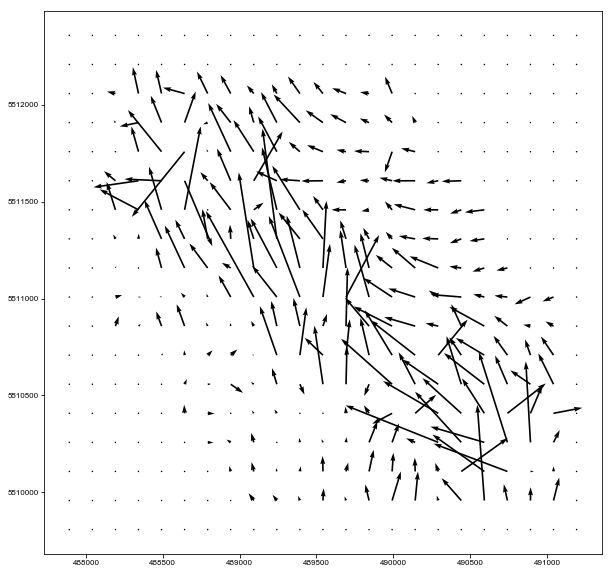

In [274]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = salem.read_shapefile(pts_file) 

df_file = loadshp_as_gpd(pts_file)
df_file.crs

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]

# ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

# shp_plt = reproject(df, VX)

X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
# ax.set_xlim(502500, 507500)
# ax.set_ylim( 5624000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ str(year)+'_quiver.pdf', dpi=300)

# grid.ij_coordinates
# v_crs = check_crs(vx)

In [275]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem',
       'farin',
       #'msk',
       ]

In [276]:
M = xr.merge([vx,vy,gpr,H_opt,dem,farin]) #dem

In [277]:
df

,id,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y
0,0,265,0.0,85.148165,POINT (-117.1398886280604 49.75492621066393),-117.139889,-117.139889,49.754926,49.754926,-117.139889,49.754926,489923.722473,5.511392e+06
1,0,265,10.0,85.148165,POINT (-117.1396687236013 49.75493662985095),-117.139669,-117.139669,49.754937,49.754937,-117.139669,49.754937,489939.564498,5.511393e+06
2,0,265,20.0,85.148165,POINT (-117.1395304136233 49.75494440393425),-117.139530,-117.139530,49.754944,49.754944,-117.139530,49.754944,489949.528665,5.511394e+06
3,0,265,30.0,85.148165,POINT (-117.1393921036007 49.7549521778525),-117.139392,-117.139392,49.754952,49.754952,-117.139392,49.754952,489959.492833,5.511395e+06
4,0,265,40.0,85.148165,POINT (-117.1392537935336 49.75495995160565),-117.139254,-117.139254,49.754960,49.754960,-117.139254,49.754960,489969.457000,5.511396e+06
5,0,265,50.0,85.148165,POINT (-117.1391154834219 49.75496772519373),-117.139115,-117.139115,49.754968,49.754968,-117.139115,49.754968,489979.421168,5.511397e+06
6,0,265,60.0,85.148165,POINT (-117.1389771732657 49.75497549861672),-117.138977,-117.138977,49.754975,49.754975,-117.138977,49.754975,489989.385335,5.511398e+06
7,0,265,70.0,85.148165,POINT (-117.1388388630649 49.75498327187464),-117.138839,-117.138839,49.754983,49.754983,-117.138839,49.754983,489999.349503,5.511398e+06
8,0,265,80.0,85.148165,POINT (-117.1387005528196 49.75499104496749),-117.138701,-117.138701,49.754991,49.754991,-117.138701,49.754991,490009.313670,5.511399e+06
9,0,265,90.0,85.148165,POINT (-117.1385622425297 49.75499881789524),-117.138562,-117.138562,49.754999,49.754999,-117.138562,49.754999,490019.277837,5.511400e+06


In [278]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [279]:
df

,id,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem,farin
0,0,265,0.0,85.148165,POINT (-117.1398886280604 49.75492621066393),-117.139889,-117.139889,49.754926,49.754926,-117.139889,49.754926,489923.722473,5.511392e+06,-0.846839,0.727017,0.000000,16.608432,2358.346843,19.534802
1,0,265,10.0,85.148165,POINT (-117.1396687236013 49.75493662985095),-117.139669,-117.139669,49.754937,49.754937,-117.139669,49.754937,489939.564498,5.511393e+06,-0.925040,0.999728,NaN,20.851753,2354.573290,22.012766
2,0,265,20.0,85.148165,POINT (-117.1395304136233 49.75494440393425),-117.139530,-117.139530,49.754944,49.754944,-117.139530,49.754944,489949.528665,5.511394e+06,-1.096846,1.202009,43.658606,20.851753,2352.476328,24.338326
3,0,265,30.0,85.148165,POINT (-117.1393921036007 49.7549521778525),-117.139392,-117.139392,49.754952,49.754952,-117.139392,49.754952,489959.492833,5.511395e+06,-1.222261,1.373226,43.670108,24.155726,2350.299415,26.611160
4,0,265,40.0,85.148165,POINT (-117.1392537935336 49.75495995160565),-117.139254,-117.139254,49.754960,49.754960,-117.139254,49.754960,489969.457000,5.511396e+06,-1.565445,1.633612,43.787786,27.478699,2348.627449,26.611160
5,0,265,50.0,85.148165,POINT (-117.1391154834219 49.75496772519373),-117.139115,-117.139115,49.754968,49.754968,-117.139115,49.754968,489979.421168,5.511397e+06,-1.821099,1.748751,44.017885,27.478699,2346.987852,30.293516
6,0,265,60.0,85.148165,POINT (-117.1389771732657 49.75497549861672),-117.138977,-117.138977,49.754975,49.754975,-117.138977,49.754975,489989.385335,5.511398e+06,-1.885330,1.794574,44.254898,35.112469,2345.444231,30.293516
7,0,265,70.0,85.148165,POINT (-117.1388388630649 49.75498327187464),-117.138839,-117.138839,49.754983,49.754983,-117.138839,49.754983,489999.349503,5.511398e+06,-2.112373,1.903797,44.498819,35.112469,2344.323026,31.783417
8,0,265,80.0,85.148165,POINT (-117.1387005528196 49.75499104496749),-117.138701,-117.138701,49.754991,49.754991,-117.138701,49.754991,490009.313670,5.511399e+06,-1.965720,1.653596,44.749653,35.112469,2343.623825,33.513923
9,0,265,90.0,85.148165,POINT (-117.1385622425297 49.75499881789524),-117.138562,-117.138562,49.754999,49.754999,-117.138562,49.754999,490019.277837,5.511400e+06,-2.564132,1.734058,44.988775,35.112469,2342.986362,33.591708


In [280]:
df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [281]:
# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))
    


In [282]:
D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt', 'dem', 'farin']].copy()
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,dem,farin
ij,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.127502,64.095955,2690.673340,37.186405
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,-3.461551,10.871938,39.990501,64.095955,2690.420898,36.718430
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.716499,58.278130,2687.506104,36.718430
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,0.000000,20.840923,2686.508301,16.126112
0262_0263,2,1986,30.0,113.499646,-117.149891,49.751754,-2.133994,12.567749,39.442501,50.455193,2683.484375,38.353989
0262_0312,3,1847,10.0,113.508674,-117.149873,49.749590,0.123284,3.128877,NaN,30.956926,2682.486816,19.738256
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,-2.816563,16.343544,39.168499,50.455193,2679.908936,38.353989
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,-1.015924,2.891252,NaN,30.956926,2679.775879,19.738256
0266_0265,2,1986,50.0,113.499646,-117.149636,49.751683,-3.562577,15.348568,37.446999,50.455193,2676.887695,38.353989


In [283]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.id==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.id==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt
D['Qopt'] = (D.vfg - off_ice_V + sVZ) * Dint * d * D.H_opt     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a'] = 20. * D.H_opt #area per slice

##calculate flux for lowest two bins assuming surface vel. = depth integrated vel.
# KP=[]
# for loop in D.index:
#     ID= D[D.index==loop].id.values
#     if ((ID==0) | (ID==1)):
#         KP.append( (D[D.index==loop].vfg * 1.0 * 20. * D.H_opt[D.index==loop]).values[0])
#     else:
#         KP.append((D[D.index==loop].vfg * 0.9 * 20. * D.H_opt[D.index==loop]).values[0]  )  ## ice flux per slice *0.9 to est. depth-integrated velocity
# D['Qopt'] = KP
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.id==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.id==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt
D['Qfarin'] = (D.vfg- off_ice_V+sVZ) * Dint * d * D.farin     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a_farin'] = 20. * D.farin #area per slice

### Uncertainties
# D['sQopt'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt * D.H_opt)**2) * (D.vfg*0.9)**2) * d**2) #d=10 meters, point spacing
D['sQopt'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt)**2) * (D.vfg*Dint)**2) * d**2)

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [284]:
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,dem,farin,vz,vzdir,vfg,Qopt,a,Qfarin,a_farin,sQopt
ij,,,,,,,,,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.127502,64.095955,2690.673340,37.186405,12.066653,-17.714619,9.077151,7651.698366,1281.919098,4439.268535,743.728088,28566.839023
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,-3.461551,10.871938,39.990501,64.095955,2690.420898,36.718430,11.409705,-17.661119,8.589977,7339.439492,1281.919098,4204.519497,734.368591,27033.646083
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.716499,58.278130,2687.506104,36.718430,11.093633,-15.297392,8.646048,6705.935041,1165.562592,4225.108205,734.368591,24740.325106
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,0.000000,20.840923,2686.508301,16.126112,2.702985,NaN,NaN,NaN,416.818466,NaN,322.522247,NaN
0262_0263,2,1986,30.0,113.499646,-117.149891,49.751754,-2.133994,12.567749,39.442501,50.455193,2683.484375,38.353989,12.747637,-9.636866,10.674496,6829.223914,1009.103851,5191.298718,767.079773,26444.512990
0262_0312,3,1847,10.0,113.508674,-117.149873,49.749590,0.123284,3.128877,NaN,30.956926,2682.486816,19.738256,3.131305,NaN,NaN,NaN,619.138527,NaN,394.765137,NaN
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,-2.816563,16.343544,39.168499,50.455193,2679.908936,38.353989,16.584463,-9.778018,13.864965,8438.981344,1009.103851,6414.970951,767.079773,34348.437493
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,-1.015924,2.891252,NaN,30.956926,2679.775879,19.738256,3.064546,-19.360382,2.246037,1580.898118,619.138527,1007.986779,394.765137,3413.961239
0266_0265,2,1986,50.0,113.499646,-117.149636,49.751683,-3.562577,15.348568,37.446999,50.455193,2676.887695,38.353989,15.756601,-13.067608,12.655042,7828.512450,1009.103851,5950.917286,767.079773,31351.029336


In [285]:
# [FG.sQopt[1:]]

In [286]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]
sQopt= [0.,]


for n in range(D.id.nunique()+1):
        Q_out.append(D.Qopt[D.id==n].sum()) 
        cr_area.append(D.a[D.id==n].sum())
        vzdir.append(D.vzdir[D.id==n].mean())
        sQopt.append(D.sQopt[D.id==n].sum()) 
#         area_Qin.append(D.[D.id==n].sum()) 
Q_in = [Q_out[1:]]
sQin = [sQopt[1:]]
# area_Qin = 
# area_Qin= 
Q_in = np.squeeze(Q_in)
sQin = np.squeeze(sQin)


Q_outF= [0.,] #flux out per gate
cr_areaF = [0.,]
for n in range(D.id.nunique()+1):
        Q_outF.append(D.Qfarin[D.id==n].sum()) 
        cr_areaF.append(D.a_farin[D.id==n].sum())         
Q_inF = [Q_outF[1:]] #flux in per bin
Q_inF = np.squeeze(Q_inF)


FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQopt, sQin, Q_outF, Q_inF, cr_areaF, vzdir)), columns=['Q_out', 
                'Q_in', 'cr_area', 'sQopt', 'sQin', 'Q_outF', 'Q_inF', 'cr_areaF', 'vzdir']) 

FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['vfgF'] = FG.Q_outF / FG.cr_area
FG['bin']=np.arange(0,len(range(D.id.nunique()+1)),1)
# FG['sQnet_opt'] = np.sqrt(FG.sQopt**2 + FG.sQin**2)

FG

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,vfgF,bin
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,NaN,0
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,2.216402,1
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,1.456674,2
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,2.288102,3
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,2.179676,4


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

Original vector layer projection:  {'init': 'epsg:2955'}
New vector layer projection (PROJ4):  +init=epsg:2955


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:2955


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


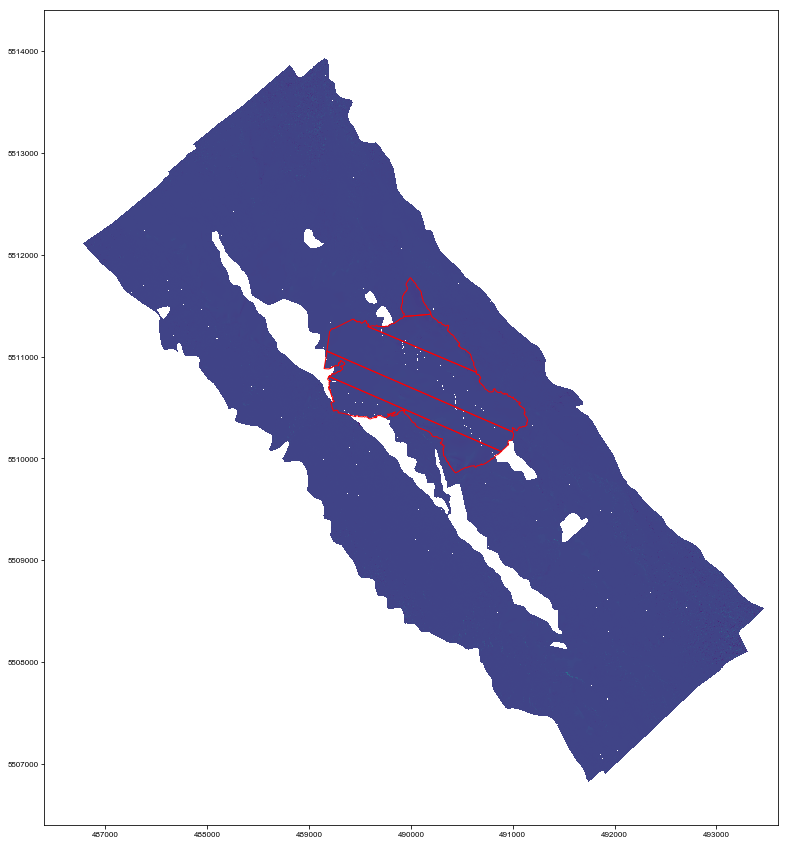

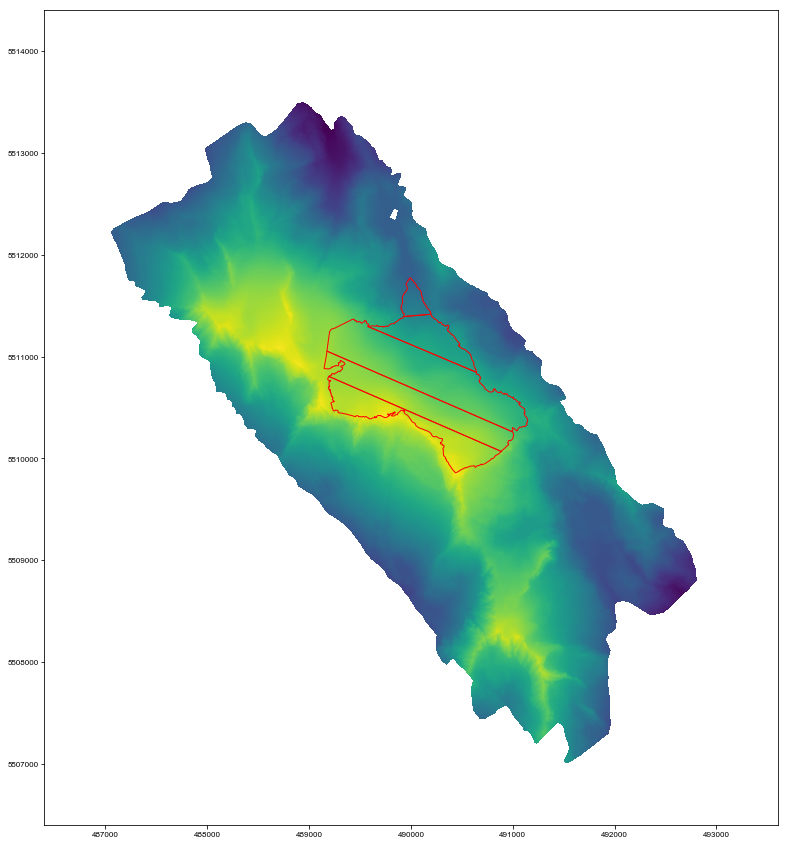

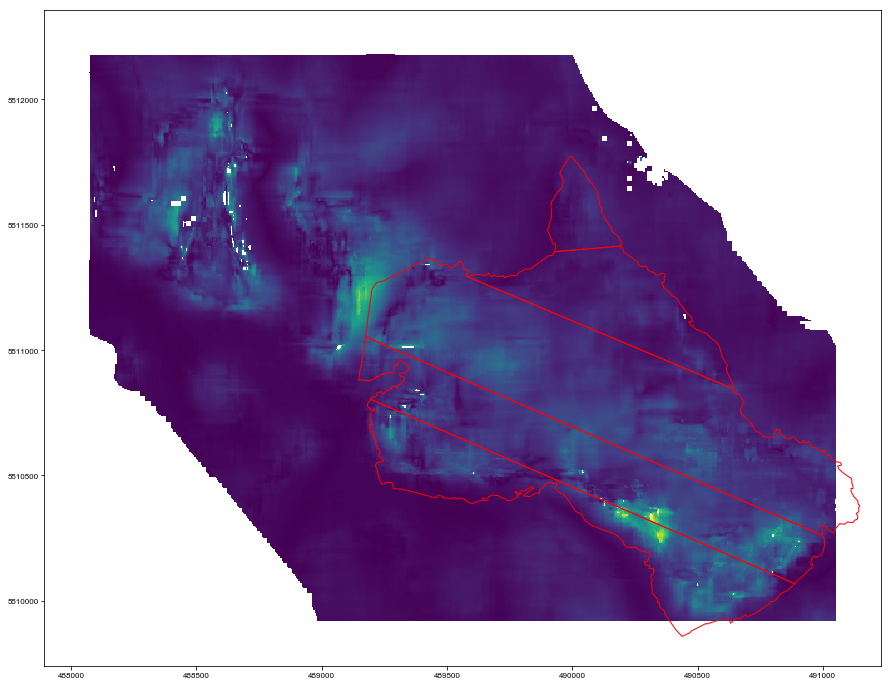

In [287]:
FG_df = FG.copy()
dem_r = topo
vel_r = vdir + vf[:-1] + '-F_vm.tif'
shp = loadshp_as_gpd(bins)

rasters = [dh_r, dem_r, vel_r]
names = ['dh','dem','vm']
for i in range(len(rasters)):
    raster = rasters[i]
    rst = rasterio.open(raster)
    shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
    # dhdt= vx.salem.transform(dhdt)
    name = names[i]
#     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
    stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
    ZS = (get_zonal_stats(shp, raster, stats))
    ZS.drop(['geometry'], axis=1, inplace=True)
    ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
    ZS.sort_values(by=['bin'],ascending=True, inplace=True)
    ZS.set_index('bin', inplace=True)
    FG_df =  pd.concat([FG_df, ZS], axis=1)
    

In [288]:
rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
rho.set_index('bin', inplace=True) # set bin as index for sorting
rho[0:4]
FG_df =  pd.concat([FG_df, rho], axis=1)
FG_df

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,firnA,vm_mean,vm_med,perc_firn,vm_std,rho_2016,rho_2017,rho_2018,mean,Vfirn
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,0.000,3.181572,3.384886,NaN,1.426458,910,910,910,910.000000,0.000
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,0.000,3.221922,3.059077,NaN,1.223438,910,910,910,910.000000,0.000
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,0.325,7.008279,6.499762,0.0,2.952528,850,750,950,850.000000,0.010
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,0.808,7.856762,7.003767,NaN,4.278890,600,600,625,608.333333,0.090
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,0.668,7.768203,6.971347,NaN,5.519489,600,600,600,600.000000,0.018


In [289]:
FG_df.dem_count

0     63555
1    226674
2    741064
3    419741
4    336893
Name: dem_count, dtype: int64

In [290]:
# FG_df['area_Qin']= [FG_df.dem_count[1:]]
FG_df

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,firnA,vm_mean,vm_med,perc_firn,vm_std,rho_2016,rho_2017,rho_2018,mean,Vfirn
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,0.000,3.181572,3.384886,NaN,1.426458,910,910,910,910.000000,0.000
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,0.000,3.221922,3.059077,NaN,1.223438,910,910,910,910.000000,0.000
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,0.325,7.008279,6.499762,0.0,2.952528,850,750,950,850.000000,0.010
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,0.808,7.856762,7.003767,NaN,4.278890,600,600,625,608.333333,0.090
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,0.668,7.768203,6.971347,NaN,5.519489,600,600,600,600.000000,0.018


In [291]:
WR= np.array(FG_df.dem_count[1:])
WR= np.append(WR,[0])

In [292]:
FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count

FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count


FG_df['area_Qin']= WR
FG_df['sQoptA'] = FG_df.sQopt / FG_df.dem_count
FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)


##calculate height change due to mass balance for highest bins considering firn compaction
# KP=[]
# for loop in FG_df.index:
#     ID= FG_df[FG_df.index==loop].bin.values #.id.values
#     if (ID==2):
#         KP.append( (FG_df[FG_df.index==loop].dh_mean - FG_df.Q_netA[FG_df.index==loop] + 0.01).values[0])
#     elif (ID==3):
#         KP.append( (FG_df[FG_df.index==loop].dh_mean - FG_df.Q_netA[FG_df.index==loop] + 0.09).values[0])
#     elif (ID==4):
#         KP.append( (FG_df[FG_df.index==loop].dh_mean - FG_df.Q_netA[FG_df.index==loop] + FG_df.Vfirn[FG_df.index==loop]).values[0])
#     else:
#         KP.append( (FG_df[FG_df.index==loop].dh_mean - FG_df.Q_netA[FG_df.index==loop]).values[0])  
# FG_df['b_fg_h'] = KP

##calculate height change due to mass balance for highest bins considering firn compaction
FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

# FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
if balance == 'bw':
    FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
else:
    FG_df['b_fg_we'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h
       
if balance == 'bw':
    FG_df['b_fg_weF'] = rho_snow/1000. * FG_df.b_fg_hF
else:
    FG_df['b_fg_weF'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_hF
# FG_df.drop(FG_df.tail(1).index,inplace=True)

FG_df

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,Q_netF,Q_netAF,area_Qin,sQoptA,sQ_inA,sQnetA_opt,b_fg_h,b_fg_hF,b_fg_we,b_fg_weF
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,35731.468644,0.562213,226674,0.000000,0.264178,0.264178,-2.620365,-2.627856,-2.384532,-2.391349
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,149306.265995,0.658683,741064,0.264178,0.542989,0.603844,-1.861319,-1.529415,-1.693800,-1.391768
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,263375.853949,0.355402,419741,0.542989,3.755409,3.794461,-0.607435,-0.583812,-0.455576,-0.437859
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,-98135.515039,-0.233800,336893,3.755409,3.042550,4.833240,0.498972,0.352077,0.299383,0.211246
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,-350278.073549,-1.039731,0,3.042550,0.000000,3.042550,0.904549,0.813701,0.542729,0.488221


In [293]:
### Uncertainties
sDHdt = 0.04 #m Bias dh from Pelto et al. 2019
sVfirn = 0.10
sRHO = 0.05 # percent uncertainty in density

# if FG_df.Vfirn > 0.00:
# FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnet_opt / FG_df.dem_count)**2 + (FG_df.Vfirn*sVfirn)**2) #FG_df.sQnet_opt / FG_df.dem_count
FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)
# FG_df['sV'] = np.sqrt((sDH * FG_df.dem_count)**2)  #assume negligible area error
# if FG_df['rho_%s'%year] < 900.:
#     FG_df['sV'] = (sDH * (FG_df['rho_%s'%year]/1000.))**2 + ((FG_df['rho_%s'%year]*sRHO/1000.)*FG_df.dV)**2 +
#         FG_df.sQn
# else:
# FG_df['sM'] = ((FG_df.sV * (FG_df['rho_%s'%year]))**2 + ((FG_df['rho_%s'%year]*sRHO)*FG_df.dV)**2 
#                + (FG_df.sQnet_opt * (FG_df['rho_%s'%year]*sRHO/1000.))**2) / FG_df.dem_count / 1000.
#                 #(FG_df.dem_count/(FG_df.dem_count.sum()))


FG_df

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,area_Qin,sQoptA,sQ_inA,sQnetA_opt,b_fg_h,b_fg_hF,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,226674,0.000000,0.264178,0.264178,-2.620365,-2.627856,-2.384532,-2.391349,0.267189,0.260675
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,741064,0.264178,0.542989,0.603844,-1.861319,-1.529415,-1.693800,-1.391768,0.605167,0.552125
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,419741,0.542989,3.755409,3.794461,-0.607435,-0.583812,-0.455576,-0.437859,3.794672,2.846018
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,336893,3.755409,3.042550,4.833240,0.498972,0.352077,0.299383,0.211246,4.833413,2.900048
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,0,3.042550,0.000000,3.042550,0.904549,0.813701,0.542729,0.488221,3.042813,1.825703


In [294]:
D['Agpr']=np.NaN
D.sort_values(by=['distance'],ascending=True, inplace=True) 
D = D.dropna(subset=['gpr'])
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] * D.gpr[D.id==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 * D.gpr[D.id==n][c]
        elif c==len(D.id[D.id==n])-2: #
            G= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 * D.gpr[D.id==n]
        elif c==len(D.id[D.id==n])-1:  #last point in line
            G= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] * D.gpr[D.id==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))* D.gpr[D.id==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.id==n] * D.gpr[D.id==n]
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            L= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] 
        elif c==1:
            L= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 
        elif c==len(D.id[D.id==n])-2: #
            L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 
        elif c==len(D.id[D.id==n])-1:  #last point in line
            L= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] 
        else:
            L=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))
       
        D.loc[idx,'Len_gpr']= L

#calculate flux out using GPR thicknesses
D['Qo_gpr'] = D.Agpr * (D.vfg - off_ice_V+sVZ) * Dint#* 0.9

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [295]:
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,...,vzdir,vfg,Qopt,a,Qfarin,a_farin,sQopt,Agpr,Len_gpr,Qo_gpr
ij,,,,,,,,,,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.127502,64.095955,...,-17.714619,9.077151,7651.698366,1281.919098,4439.268535,743.728088,28566.839023,10.000000,10.0,119.378803
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,0.000000,20.840923,...,NaN,NaN,NaN,416.818466,NaN,322.522247,NaN,110.000000,110.0,NaN
0406_0193,0,265,0.0,85.148165,-117.139889,49.754926,-0.844420,0.700265,0.000000,16.369110,...,-50.331593,0.769176,594.183222,327.382202,661.823693,364.650635,618.216097,10.000000,10.0,36.299055
0337_0212,1,1153,0.0,112.887308,-117.144709,49.754050,-2.790480,4.117406,0.000000,39.757473,...,-34.126575,2.707976,2213.976698,795.149460,1618.492427,581.281372,5286.235144,90.000000,90.0,501.183521
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,-3.461551,10.871938,39.990501,64.095955,...,-17.661119,8.589977,7339.439492,1281.919098,4204.519497,734.368591,27033.646083,199.952507,5.0,2289.597415
0410_0193,0,265,10.0,85.148165,-117.139669,49.754937,-0.968422,1.061248,43.642002,20.851753,...,-42.381409,1.139354,834.087591,417.035065,880.529069,440.255310,1166.508199,218.210011,5.0,872.858316
0412_0193,0,265,20.0,85.148165,-117.139530,49.754944,-1.133287,1.259251,43.642002,20.851753,...,-41.986233,1.350591,878.134197,417.035065,1120.681297,532.223206,1382.779520,436.420021,10.0,1837.904662
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.716499,58.278130,...,-15.297392,8.646048,6705.935041,1165.562592,4225.108205,734.368591,24740.325106,397.164993,10.0,4570.089440
0413_0193,0,265,30.0,85.148165,-117.139392,49.754952,-1.176014,1.345242,43.642002,20.851753,...,-41.160042,1.439888,896.754124,417.035065,1144.444184,532.223206,1474.204413,436.420021,10.0,1876.875528


In [296]:
# D.to_csv(fl_path+'test_dropna.csv') #'kokanee_gpr_fluxG_pts.csv')
for i in range(len(range(D.id.nunique()+1))):
    print(i, D.Agpr[D.id==i].mean())

0 345.3302973994502
1 1115.2476649381676
2 746.1197600942669
3 1063.6757352458897
4 nan


In [297]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
n=0
for n in range(D.id.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.id==n].sum())
        vzdir_gpr.append(D.vzdir[D.id==n].mean())           
Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
Qin_gpr = np.squeeze(Qin_gpr)

In [298]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr)), columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr']) 
FG_gpr['bin'] = np.arange(0,len(range(D.id.nunique()+1)),1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)
FG_gpr

,Qo_gpr,Qin_gpr,cr_area_gpr,bin
0,0.000000,41503.004059,0.000000,0
1,41503.004059,223719.746589,9323.918030,1
2,223719.746589,509535.844242,54647.135582,2
3,509535.844242,357882.520782,98487.808332,3
4,357882.520782,0.000000,71266.274261,4


In [299]:
FG_df

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,area_Qin,sQoptA,sQ_inA,sQnetA_opt,b_fg_h,b_fg_hF,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,226674,0.000000,0.264178,0.264178,-2.620365,-2.627856,-2.384532,-2.391349,0.267189,0.260675
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,741064,0.264178,0.542989,0.603844,-1.861319,-1.529415,-1.693800,-1.391768,0.605167,0.552125
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,419741,0.542989,3.755409,3.794461,-0.607435,-0.583812,-0.455576,-0.437859,3.794672,2.846018
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,336893,3.755409,3.042550,4.833240,0.498972,0.352077,0.299383,0.211246,4.833413,2.900048
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,0,3.042550,0.000000,3.042550,0.904549,0.813701,0.542729,0.488221,3.042813,1.825703


In [300]:
FG_all = FG_df.merge(FG_gpr, how='left') #on='bin')  

In [301]:
FG_all

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,sQnetA_opt,b_fg_h,b_fg_hF,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt,Qo_gpr,Qin_gpr,cr_area_gpr
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,0.264178,-2.620365,-2.627856,-2.384532,-2.391349,0.267189,0.260675,0.000000,41503.004059,0.000000
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,0.603844,-1.861319,-1.529415,-1.693800,-1.391768,0.605167,0.552125,41503.004059,223719.746589,9323.918030
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,3.794461,-0.607435,-0.583812,-0.455576,-0.437859,3.794672,2.846018,223719.746589,509535.844242,54647.135582
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,4.833240,0.498972,0.352077,0.299383,0.211246,4.833413,2.900048,509535.844242,357882.520782,98487.808332
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,3.042550,0.904549,0.813701,0.542729,0.488221,3.042813,1.825703,357882.520782,0.000000,71266.274261


In [302]:
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count 
FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr  #dh1516_mean
if balance == 'bw':
    FG_all['b_fg_we_gpr'] = rho_snow/1000. * FG_all.b_fg_h_gpr
else:
    FG_all['b_fg_we_gpr'] = FG_all['rho_%s'%year]/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)
FG_all['dem_mean']

0    2291.147384
1    2424.755905
2    2559.920028
3    2656.073264
4    2717.695553
Name: dem_mean, dtype: float64

In [303]:
FG_all

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,b_fg_weF,sDH_opt,sBwe_opt,Qo_gpr,Qin_gpr,cr_area_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,b_fg_we_gpr
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,-2.391349,0.267189,0.260675,0.000000,41503.004059,0.000000,41503.004059,0.653025,-2.718667,-2.473987
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,-1.391768,0.605167,0.552125,41503.004059,223719.746589,9323.918030,182216.742530,0.803871,-1.674604,-1.523890
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,-0.437859,3.794672,2.846018,223719.746589,509535.844242,54647.135582,285816.097653,0.385683,-0.624093,-0.468070
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,0.211246,4.833413,2.900048,509535.844242,357882.520782,98487.808332,-151653.323460,-0.361302,0.389579,0.233747
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,0.488221,3.042813,1.825703,357882.520782,0.000000,71266.274261,-357882.520782,-1.062303,0.818274,0.490964


## Plot balance gradients

In [304]:
# from scipy import stats
# from scipy.optimize import curve_fit
# from scipy.interpolate import interp1d
# import statsmodels.api as stm

# from matplotlib.collections import PatchCollection
# from matplotlib.patches import Rectangle


# font = {'family' : 'Arial',
# 'weight' : 'normal',
# 'size'   : 8}

# plt.rc('font', **font)

# fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# # j,k=0,0    ## only define j if one row
# n = 0
# s= 15 #markersize

# a = 0.9
# color=['b', 'lime', 'green', 'teal']

# ##all_obs
# if balance == 'bw':
#     obs = obs.dropna(subset=['Bw'])
#     y_ax_obs=obs[(obs.Year==year)].Bw

# else:
#     obs = obs.dropna(subset=['Ba'])
#     y_ax_obs=obs[(obs.Year==year)].Ba


# x_ax_obs=obs[(obs.Year==year)].Elev
# ##obs by bin
# # x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# # y_ax_obs=FG_df.b_obs16#b_obs

# # Drop unrealistic FG smb:
# new = FG_all.copy()

# new = new[new.b_fg_we >-8.]
# new = new[new.b_fg_we_gpr >-8.]

# #errors (above and below)
# new['yerr'] = 0.20
# yerr = new.yerr
# new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
# xerr = new.xerr 

 
# x_ax_fg_gpr=new.dem_mean
# y_ax_fg_gpr=new.b_fg_we_gpr

# x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
# y_ax_fg_opt=new.b_fg_we
# x_ax_fg_F=new.dem_mean  
# y_ax_fg_F=new.b_fg_weF

# ###############################################

# def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
#                      edgecolor='None', ecolor='None', alpha=0.5):

#     # Create list for all the error patches
#     errorboxes = []
    
#     # Loop over data points; create box from errors at each point
#     for x, y, xe, ye in zip(xdata, ydata, xerror, yerror):
#         rect = Rectangle((x - xe, y), xe, 0.05)
#         errorboxes.append(rect)

# #     # Create patch collection with specified colour/alpha
# #     pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
# #                          edgecolor=edgecolor)
# #     # Add collection to axes
# #     ax.add_collection(pc)

#     # Plot errorbars
#     artists = ax.errorbar(xdata, ydata, xerr=None, yerr=yerror, fmt='None', ecolor='k', zorder=2,
#                           elinewidth=0.7, marker='d', label='', ls='..', alpha=0.4)
            

#     return artists #, theives

# ###############################################


# x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
# y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]
# color = ['#1f78b4', '#74c476', '#238b45', 'teal']
# label = ['Obs.', 'Fg gpr', 'Fg opt.','Farinotti']

# # Call function to create error bars 
# for i in range(2):
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])
    
# ## create range bar to represent flux gate elevation range
# # theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
# #                           elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

# ## plot data and regression lines
# ax.scatter(x[0],y[0],color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3)
# ytxt = [0.2, 0.15, 0.1, 0.05]
# for i in range(4):
# #     fit = np.polyfit(x[i],y[i],2)
# #     y_new = np.polyval(fit,x[i])
# #     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

#     slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
# #     ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
#     ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='', alpha=a, linewidth=0.9, zorder=3)
#     print(slope, intercept, r_value, p_value, std_err)
#     txt= ['Obs. slope:     ', 'FG gpr slope:  ', 'FG opt. slope: ', 'FG Farin. slope: ']
           
# #     'H_{opt}''slope:$'
#     ax.text(0.5, ytxt[i], txt[i]+str(np.round(1000*slope,2))+ ' +/- ' + str(np.round(1000*std_err,2)), 
#             transform=ax.transAxes)
    
# if balance == 'ba':
#     ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)


# fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.08, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
# ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
# fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
# fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')

# plt.savefig(fl_path + 'products/' + glacier[gl]+'_bdot_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

# plt.show()

In [305]:
# OPT_b = []
# OPT_Z = []
# N =[]
# for i in range(len(new.b_fg_we)):
#     O = np.arange((new.b_fg_we[i] - new.sBwe_opt[i]), (new.b_fg_we[i] + new.sBwe_opt[i]), 0.1)
#     N.append(O)
#     for n in range(len(N)):
#             z = new.dem_mean[i]
#             OPT_Z.append(z)
#     OPT_b.append(N)      
# print(len(OPT_b))
# print(len(OPT_Z))
            
# print(OPT_b, len(OPT_b))
# print(OPT_Z, len(OPT_Z))

slope RLM: 0.008175707244311855
slope RLM: 0.007146378782382092


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


slope RLM: 0.007244223492943869
slope RLM: 0.006846133190321977


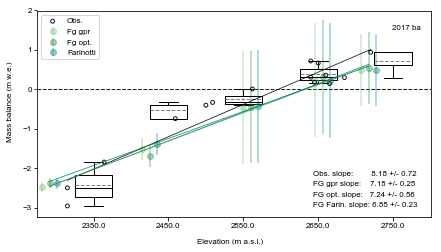

In [306]:
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.9
color=['b', 'lime', 'green', 'teal']

##all_obs
if balance == 'bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw

else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba


x_ax_obs=obs[(obs.Year==year)].Elev
##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()

new = new[new.b_fg_we >-8.]
new = new[new.b_fg_we_gpr >-8.]

#errors (above and below)
# new['yerr'] = 0.20
yerr = new.sBwe_opt * 0.5
new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
xerr = new.xerr 

 
x_ax_fg_gpr=new.dem_mean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we
x_ax_fg_F=new.dem_mean  
y_ax_fg_F=new.b_fg_weF




###############################################

def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', ecolor='None', alpha=0.5, hue='None', palette='None'):

    # Create list for all the error patches
    errorboxes = []
    
    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror, yerror):
        rect = Rectangle((x - xe, y), xe, 0.05)
        errorboxes.append(rect)

#     # Create patch collection with specified colour/alpha
#     pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
#                          edgecolor=edgecolor)
#     # Add collection to axes
#     ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=None, yerr=yerror, fmt='o', ecolor='None', zorder=2,
                          elinewidth=0.7, marker='d', label='', alpha=0.4) #ls='..',

#     thieves = sns.boxplot(x=xdata, y=ydata, hue=color, palette=color, saturation=0.7)
    return artists #, thieves

###############################################


x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]
color = ['k', '#74c476', '#238b45', 'teal']
label = ['Obs.', 'Fg gpr', 'Fg opt.','Farinotti']

# Call function to create error bars 
shift = [-10,0,10]
for i in range(3):
    ax.errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr, fmt='o', ecolor=color[i+1], zorder=2,
                          label=label[i+1], alpha=0.4, c=color[i+1]) #elinewidth=0.7
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])  #[0]
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, hue=color[i+1])[1]
    
## create range bar to represent flux gate elevation range
# theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
#                           elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

## plot data and regression lines
ax.scatter(x[0],y[0],color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3)  ##plot obs data
color2 = ['b', 'y', 'purple', 'orange']
ytxt = [0.2, 0.15, 0.1, 0.05]
for i in range(4):
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
#     ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
    
#     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
#     ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='Lin', alpha=a, linewidth=0.9, zorder=3)
#     print(slope, intercept, r_value, p_value, std_err)
    txt= ['Obs. slope:        ', 'FG gpr slope:    ', 'FG opt. slope:   ', 'FG Farin. slope: ']
           
#     'H_{opt}''slope:$'

    #################### RLM  https://www.statsmodels.org/stable/rlm.html
    ###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
    exog = stm.add_constant(x[i]) #obs_data.Elev)
    rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
    rlm_results = rlm_model.fit()
    stdE=rlm_results.bse[1]
    # print(rlm_results.params)
     # ax.scatter(x[i],y[i],color=color[i], label='data', alpha=a, s=s,facecolor='', zorder=3)
    #     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
    ax.plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
            linewidth=0.8, zorder=3) # linestyle='--'
    print('slope RLM:', rlm_results.params[1])
    #############################
    ax.text(0.7, ytxt[i], txt[i]+str(np.round(1000*rlm_results.params[1],2))+ ' +/- ' + 
            str(np.round(1000*stdE,2)), transform=ax.transAxes)
    
if balance == 'ba':
    ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)
    
############ obs data box plot ################
obs_data=obs[(obs.Year==year)]
obs_data.reset_index(inplace=True)

bin_size = 100.
z_range = np.arange(2250., 2850., bin_size)
# print(z_range)
# obs_data['Elev_bin'] = np.nan

i = 0
# for n in range(len(obs_data.Ba)):

Z_F = []
Zor_F= []
OB_F=[]

for z in z_range: 
    OBS = []
    Z = []
    Zor = []
    W=0
    bin_size = 100.
    while W==0:
        for n in range(len(obs_data.Ba)):
            if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                O = obs_data.Ba[n]
                Z.append(z)
                Zor.append(obs_data.Elev[n])
                OBS.append(O)

        if len(OBS)<3:
            ##could select last element below elevation
            bin_size=bin_size*1.5
        else:
            OB_F.append(np.array(OBS))
            Z_F.append(np.array(Z))
            Zor_F.append(np.array(Zor))
            
            W=1
    i += 1
# OB_F=np.concatenate(OB_F)
# Z_F=np.concatenate(Z_F)
# Zor_F=np.concatenate(Zor_F)
# print(Z_F, len(Z_F))
# print(OB_F, len(OB_F))



# thieves = sns.boxplot(x=obs_data.Elev_bin, y=obs_data.Ba, hue=obs_data.Year, palette='BuGn', saturation=0.7, ax=ax)
# ax = sns.boxplot(x=Z_F, y=OB_F, palette='BuGn', saturation=0.7)#, ax=ax)
meanlineprops = dict(linestyle='--', linewidth=1., color='0.5')
medianprops = dict(linestyle='-', linewidth=1, color='k')
BOX=plt.boxplot(OB_F[1:],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                positions=[2350., 2450., 2550., 2650., 2750.],widths=50)
# Add jitter with the swarmplot function.
# ax = sns.swarmplot(x=Zor, y=OBS, color="grey")
# glacio = [Z, OBS]

# ax.boxplot(glacio)

############################
ax.set_xlim(2275,2800)
fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.08, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
fig.text(0.9, 0.9, str(year)+ ' '+ balance)
plt.savefig(fl_path + 'products/' + glacier[gl]+'_bdot_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

In [307]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()

In [308]:
gg = new['FG_opt_m3_we'].sum()
gg

-564595.3128724978

In [309]:
gg = new['FG_gpr_m3_we'].sum()
gg

-586014.3832337763

In [310]:
new

,Q_out,Q_in,cr_area,sQopt,sQin,Q_outF,Q_inF,cr_areaF,vzdir,vfg,...,Qo_gpr,Qin_gpr,cr_area_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,b_fg_we_gpr,xerr,FG_opt_m3_we,FG_gpr_m3_we
0,0.000000,35255.379387,0.000000,0.000000e+00,5.988230e+04,0.000000,35731.468644,0.000000,0.000000,NaN,...,0.000000,41503.004059,0.000000,41503.004059,0.653025,-2.718667,-2.473987,44.420421,-151548.921430,-157234.259881
1,35255.379387,259795.495653,16121.385384,5.988230e+04,4.023896e+05,35731.468644,185037.734639,16363.372070,-60.946827,2.186870,...,41503.004059,223719.746589,9323.918030,182216.742530,0.803871,-1.674604,-1.523890,56.158166,-383940.417145,-345426.147045
2,259795.495653,540677.498831,127027.549934,4.023896e+05,1.576299e+06,185037.734639,448413.588588,90018.593750,-44.698124,2.045190,...,223719.746589,509535.844242,54647.135582,285816.097653,0.385683,-0.624093,-0.468070,78.990885,-337611.134821,-346869.685677
3,540677.498831,380884.001463,195976.226921,1.576299e+06,1.025014e+06,448413.588588,350278.073549,162978.093750,-35.854374,2.758893,...,509535.844242,357882.520782,98487.808332,-151653.323460,-0.361302,0.389579,0.233747,46.303727,125663.441939,98113.323594
4,380884.001463,0.000000,160701.876755,1.025014e+06,0.000000e+00,350278.073549,0.000000,146490.171875,-50.442669,2.370128,...,357882.520782,0.000000,71266.274261,-357882.520782,-1.062303,0.818274,0.490964,41.598854,182841.718584,165402.385776


In [311]:
print(B_opt)
print(B_gpr)


-0.3157820833135233
-0.32776191826275697


## Plot flux gates as cross-sections

No handles with labels found to put in legend.


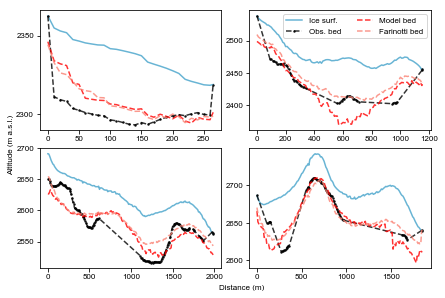

In [312]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs_H = df_agg.copy()
obs_H = obs_H.dropna(subset=['gpr']) #, inplace=True)   

fig, ax = plt.subplots(2,2)
for i in range(4):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs_H[obs_H.id==i].dem)-(obs_H[obs_H.id==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(obs_H[obs_H.id==i].distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ##plot Farinotti thickness gates
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].farin), 
                 ls='--', c='salmon', alpha=a, label='Farinotti bed')  #marker='o')
    
    ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50)) ##
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 2: 
        j += 1
        k = 0  
         
    ax[0,1].legend(ncol=2)
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.085, right=0.99, wspace=0.15, hspace=0.15) 

plt.savefig(fl_path + 'products/' + glacier[gl]+'_flux_gates.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        